In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Load csv file into a pandas dataframe
df = pd.read_csv('bquxjob_268fbef9_18f59b8ab41.csv')
df.head()

,anon_id,adm_date_jittered,disch_date_jittered,discharge_year,MSDRGWeight,CPI,Cost_Adj,observation_id_x,LOS,observation_id,...,drg_mpi_code,drg_id,drg_name,DRG_CODE_SET_C,drg_weight,match_step,Cost_Predicted,Cost_Residual,Cost_Residual_sq,Cost_Relative
0,JC2847684,2020-01-20,2020-01-21,2020,0.7385,518.876,1.789141,JC2847684_2020-01-20,1.0,131282280569,...,52,2351,ALTERATION IN CONSCIOUSNESS,3,0.7385,1,5.586767,-3.797626,14.421964,1.767342
1,JC2847684,2020-01-20,2020-01-21,2020,0.7385,518.876,1.789141,JC2847684_2020-01-20,1.0,131282280569,...,72,1637,NONSPECIFIC CEREBROVASCULAR DISORDERS WITHOUT ...,6,0.7385,1,5.586767,-3.797626,14.421964,1.767342
2,JC571693,2020-10-28,2020-10-30,2020,0.7385,518.876,5.859418,JC571693_2020-10-28,2.0,131298721167,...,199,2416,HYPERTENSION,3,0.7385,1,5.586767,0.272651,0.074339,5.788027
3,JC571693,2020-10-28,2020-10-30,2020,0.7385,518.876,5.859418,JC571693_2020-10-28,2.0,131298721167,...,305,1820,HYPERTENSION WITHOUT MCC,6,0.7385,1,5.586767,0.272651,0.074339,5.788027
4,JC3041511,2020-11-11,2020-11-14,2020,0.7385,518.876,5.886646,JC3041511_2020-11-11,3.0,131298811590,...,199,2416,HYPERTENSION,3,0.7385,1,5.586767,0.299879,0.089927,5.814923


In [3]:
# check which drg_id are the most common
df['drg_id'].value_counts().sort_values(ascending=False).head(10)

drg_id
1946    610
2334    459
2459    425
2462    405
1712    401
2384    398
2259    395
6427    371
2460    362
2412    344
Name: count, dtype: int64

In [4]:
# chek if each values of drg_id has an unique value of drg_name
temp_res = df.groupby('drg_id')['drg_name'].nunique().sort_values(ascending=False)
temp_res

drg_id
1582    1
2368    1
2370    1
2372    1
2373    1
       ..
1953    1
1955    1
1956    1
1957    1
8877    1
Name: drg_name, Length: 786, dtype: int64

In [5]:
# to be sure, check if all these are ones
(temp_res == 1).all()

True

In [6]:
# get drg_name for each drg_id
drg_pd_dic = df.groupby('drg_id').apply(lambda x: x[['drg_id', 'drg_name']].iloc[0])

# set drg_id as index
drg_pd_dic = drg_pd_dic.set_index('drg_id')
drg_pd_dic.head()

,drg_name
drg_id,
1582,HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SY...
1584,TRACHEOSTOMY WITH MV >96 HOURS OR PRINCIPAL DI...
1585,LIVER TRANSPLANT WITH MCC OR INTESTINAL TRANSP...
1586,LIVER TRANSPLANT WITHOUT MCC
1587,LUNG TRANSPLANT


In [7]:
# make drg_pd_dic a dictionary
drg_dic = drg_pd_dic.to_dict()['drg_name']

Text(0, 0.5, 'Density')

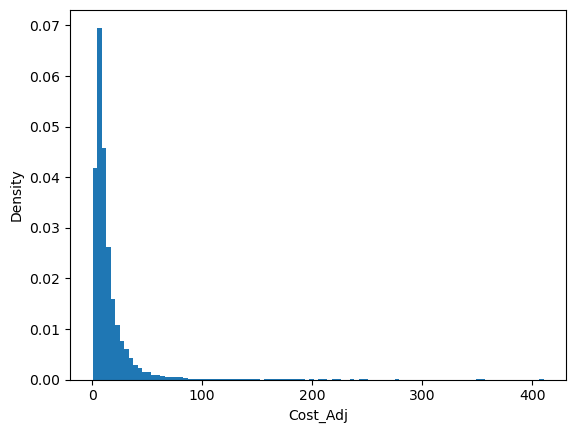

In [8]:
# plot histogram of df['Cost_Adj']
plt.hist(df['Cost_Adj'], bins=100, density=True);

# Add x-axis label
plt.xlabel('Cost_Adj')

# Add y-axis label
plt.ylabel('Density')

Not surprinsingly, because cost data cannot be negative, its empirical distribution is very positively (ie rigth) skewed. 

In [9]:
# Add ln_cost_adj column to the dataframe
df['ln_cost_adj'] = np.log(df['Cost_Adj'])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


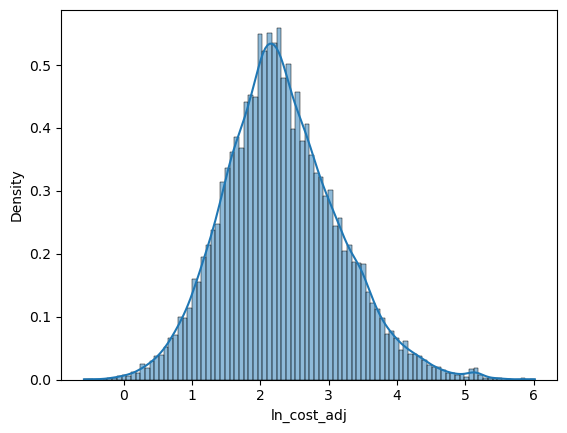

In [63]:
# Plot the histogram with seaborn using a kernel density estimate and put density as y axis
sns.histplot(df['ln_cost_adj'], kde=True, stat='density');

In [73]:
print(f'Skewness is {df["ln_cost_adj"].skew():.2f}')
print(f'Kurtosis is {df["ln_cost_adj"].kurt():.2f}')

Skewness is 0.35
Kurtosis is 0.36


Taking the log of cost cost, cost appears approximately log-normally distributed.

In [11]:
pd.concat([df['ln_cost_adj'].describe(), pd.Series({'skew': df['ln_cost_adj'].skew(), 'kurtosis': df['ln_cost_adj'].kurtosis()})]) 

count       29694.000000
mean            2.309599
std             0.839125
min            -0.580207
25%             1.749181
50%             2.251279
75%             2.823719
max             6.017413
skew            0.354759
kurtosis        0.363922
dtype: float64

In [12]:
# get summary statistics for the column ln_cost_adj grouped by drg_id
drg_df_res = df.groupby('drg_id').apply(lambda x: pd.concat([x['ln_cost_adj'].describe(), pd.Series({'skew': x['ln_cost_adj'].skew(), 'kurtosis': x['ln_cost_adj'].kurtosis()})]))
# add drg_dict to drg_df_res
drg_df_res['drg_name'] = drg_df_res.index.map(drg_dic)

# order by std
drg_df_res = drg_df_res.sort_values('std', ascending=False)

drg_df_res.head()

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,drg_name
drg_id,,,,,,,,,,,
2195,2.0,2.725309,1.712456,1.514420,2.119864,2.725309,3.330754,3.936199,NaN,NaN,SPLENECTOMY WITH CC
2302,3.0,2.967726,1.632005,1.803189,2.035045,2.266900,3.549994,4.833088,1.576067,NaN,CRANIOTOMY FOR MULTIPLE SIGNIFICANT TRAUMA
2577,3.0,3.330944,1.602072,1.514420,2.725309,3.936199,4.239206,4.542214,-1.457427,NaN,SPLENECTOMY
2524,4.0,2.256537,1.597128,0.812179,1.058794,1.977265,3.175008,4.259440,0.622864,-2.183397,"MALIGNANCY, MALE REPRODUCTIVE SYSTEM"
1646,3.0,2.422595,1.461288,1.578837,1.578920,1.579002,2.844474,4.109945,1.732051,NaN,NONTRAUMATIC STUPOR AND COMA WITHOUT MCC


In [45]:
# Assign the mean from drg_df_res to each drg
drg_mean_cost_dic = drg_df_res['mean'].to_dict()
df['drg_mean_cost'] = df['drg_id'].map(drg_mean_cost_dic)

# Assign the std from drg_df_res to each drg
drg_std_cost_dic = drg_df_res['std'].to_dict()
df['drg_std_cost'] = df['drg_id'].map(drg_std_cost_dic)

# Normalize all ln_cost_adj values given their drg_id
df['ln_cost_adj_norm'] = df.groupby('drg_id')['ln_cost_adj'].transform(lambda x: (x - x.mean()) / x.std())

# Add normality to drg_df_res
#drg_df_res['normality'] = df.groupby('drg_id')['ln_cost_adj_norm'].apply(lambda x: np.log(norm.pdf(x)).mean())

# Put on ln scale for plotting
#drg_df_res['normality_log'] = np.log(1+ drg_df_res['normality'] - np.min(drg_df_res['normality']))

# Put drg_df_res as the first column
drg_df_res.insert(0, 'drg_name', drg_df_res.pop('drg_name'))

#cutt-off count for the top 100 drgs
cutoff = drg_df_res['count'].sort_values(ascending=False).iloc[100]

drg_df_lim = drg_df_res[drg_df_res['count'] > cutoff]
drg_df_lim.sort_values('count', ascending=False).head(10)

,drg_name,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
drg_id,,,,,,,,,,,
1946,MAJOR HIP AND KNEE JOINT REPLACEMENT OR REATTA...,610.0,2.229221,0.280393,1.665683,2.054521,2.174757,2.345655,4.079484,1.948224,7.003137
2334,OPEN CRANIOTOMY EXCEPT TRAUMA,459.0,2.723538,0.560518,1.142261,2.309874,2.660393,3.050233,4.619994,0.704326,0.529762
2459,HIP JOINT REPLACEMENT,425.0,2.350911,0.376071,1.513450,2.100315,2.266806,2.484394,4.111417,1.560949,3.394375
2462,DORSAL AND LUMBAR FUSION PROCEDURE EXCEPT FOR ...,405.0,3.015693,0.459626,1.508341,2.712976,2.941194,3.281600,4.857334,0.655470,1.468031
1712,RESPIRATORY INFECTIONS AND INFLAMMATIONS WITH MCC,401.0,2.059434,0.718265,0.012772,1.550765,2.025157,2.505041,6.017413,0.489586,1.638766
2384,MAJOR RESPIRATORY INFECTIONS AND INFLAMMATIONS,398.0,2.043385,0.745945,-0.165006,1.528181,2.014451,2.503175,6.017413,0.440720,1.498827
2259,PSYCHOSES,395.0,2.147188,0.895715,0.040978,1.556232,2.135566,2.670333,4.664924,0.229890,-0.097177
6427,OTHER CHEMOTHERAPY,371.0,1.846594,0.591763,-0.071765,1.568955,1.868933,2.162018,4.006733,-0.093290,2.260295
2460,KNEE JOINT REPLACEMENT,362.0,2.265658,0.360025,1.278906,2.041182,2.179828,2.430516,3.963956,1.184476,2.268196


In [47]:
# Get the mean cost across DRGs and the mean std across DRGs
mean_mean, mean_std = drg_df_res['mean'].mean(), drg_df_res['std'].mean()

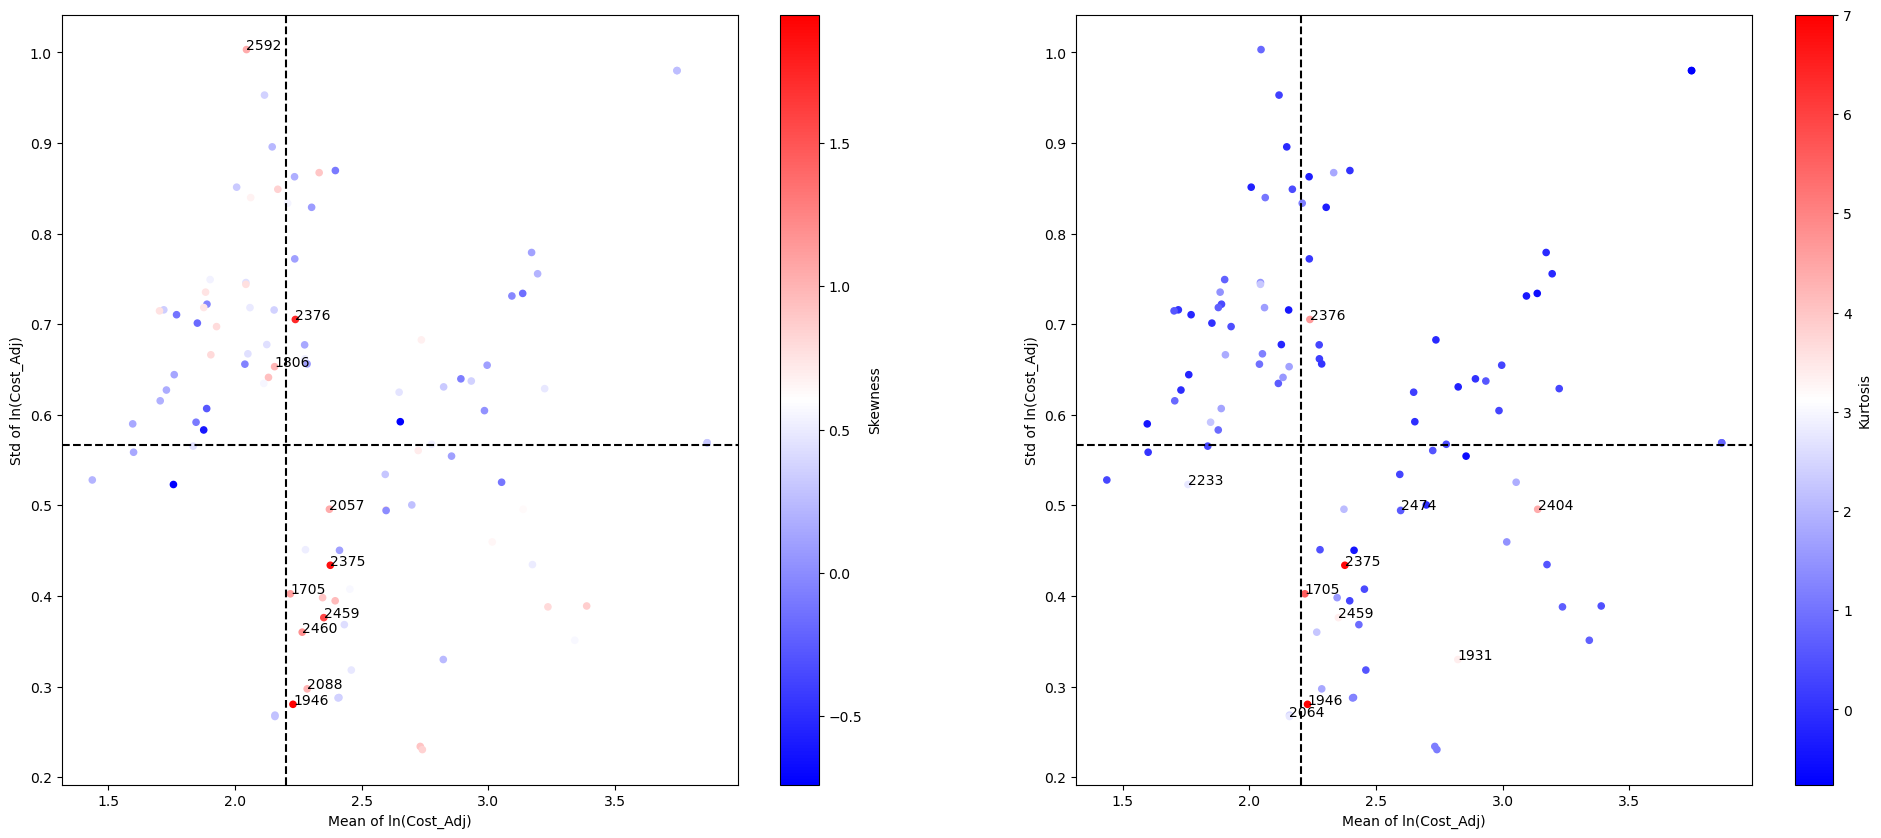

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(24, 10))  # 1 row, 2 columns

# create a colormap from blue to white to red
cmap = mcolors.LinearSegmentedColormap.from_list("", ['blue', 'white', 'red'])

# Plot 1
# plot std vs mean and color the dots by counts
scatter = axs[0].scatter(drg_df_lim['mean'], drg_df_lim['std'], c= drg_df_lim['skew'], cmap=cmap, s=20, alpha=1)

# sort DataFrame by 'skew' and select top 10
top_skew = drg_df_lim.sort_values('skew', ascending=False).head(10)

# add text identifiers for top 10 skew
for i in top_skew.index:
    axs[0].text(top_skew['mean'].loc[i], top_skew['std'].loc[i], i)

# add legend for the color
fig.colorbar(scatter, ax=axs[0], label='Skewness')

# add vertical line for the mean of the mean cost across DRGs
axs[0].axvline(x=mean_mean, color='black', linestyle='--')

# add horizontal line for the mean of the mean std across DRGs
axs[0].axhline(y=mean_std, color='black', linestyle='--')

# add labels
axs[0].set_xlabel('Mean of ln(Cost_Adj)')
axs[0].set_ylabel('Std of ln(Cost_Adj)')

# Plot 2
# plot std vs mean and color the dots by counts
scatter = axs[1].scatter(drg_df_lim['mean'], drg_df_lim['std'], c=drg_df_lim['kurtosis'], cmap=cmap, s=20, alpha=1)

# sort DataFrame by 'kurtosis' and select top 10
top_kurtosis = drg_df_lim.sort_values('kurtosis', ascending=False).head(10)

# add text identifiers for top 10 kurtosis
for i in top_kurtosis.index:
    axs[1].text(top_kurtosis['mean'].loc[i], top_kurtosis['std'].loc[i], i)

# add legend for the color
fig.colorbar(scatter, ax=axs[1], label='Kurtosis')

# add vertical line for the mean of the mean cost across DRGs
axs[1].axvline(x=mean_mean, color='black', linestyle='--')

# add horizontal line for the mean of the mean std across DRGs
axs[1].axhline(y=mean_std, color='black', linestyle='--')

# add labels
axs[1].set_xlabel('Mean of ln(Cost_Adj)')
axs[1].set_ylabel('Std of ln(Cost_Adj)')

#plt.tight_layout()
plt.show()